**This notebook**: same as the dedicated QBR explorations, but within key lightness ranges (i.e., 45-70), attempt to normalize the accent chroma curves. The idea: there's a consistent order to the *distinction* between accents. Since chroma is the only free parameter at this point that determines perceptual distinction, and *fixing* that chroma is out of the question (leads to dull schemes, on the whole), we'd like the *relative distinction/role* of each accent to remain consistent across lightness values.

In [1]:
import json
from pathlib import Path
from functools import cache

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, CubicSpline, BSpline

from coloraide import Color

@cache
def max_C_Lh(L, h, space='srgb', eps=1e-6, tol=1e-9):
    '''
    Binary search for max chroma at fixed lightness and hue

    Parameters:
        L: lightness percentage
    '''
    def C_in_gamut(C):
        return Color('oklch', [L/100, C, h]).convert(space).in_gamut(tolerance=tol)

    lo, hi = 0.0, 0.1
    while C_in_gamut(hi): hi *= 2
    while hi - lo > eps:
        m = (lo + hi) / 2
        lo, hi = (m, hi) if C_in_gamut(m) else (lo, m)

    Cmax = lo
    c_oklch = Color('oklch', [L, Cmax, h])
    c_srgb  = c_oklch.convert('srgb')
    
    return Cmax

def quad_bezier_rational(P0, P1, P2, w, t):
    t = np.asarray(t)[:, None]
    num = (1-t)**2*P0 + 2*w*(1-t)*t*P1 + t**2*P2
    den = (1-t)**2 + 2*w*(1-t)*t + t**2
    
    return num/den
    
def bezier_y_at_x(P0, P1, P2, w, x_query, n=400):
    t = np.linspace(0, 1, n)
    B = quad_bezier_rational(P0, P1, P2, w, t)
    x_vals, y_vals = B[:, 0], B[:, 1]
    
    return np.interp(x_query, x_vals, y_vals)

In [2]:
# SET LIGHTNESS CONTROL POINTS
# L_points = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 98]
L_points = list(range(10, 98+1))

In [3]:
# FIXED MONOBIOME PARAMETERS
L_resolution = 5  # step size along lightness dim
L_space = np.arange(0, 100+L_resolution, L_resolution)

monotone_C_map = {
    "alpine": 0,
    "badlands": 0.011,
    "chaparral": 0.011,
    "savanna": 0.011,
    "grassland": 0.011,
    "tundra": 0.011,
}

h_weights = {
    "red": 3.2,
    "orange": 3.8,  # 3.6
    "yellow": 3.8,  # 4.0
    "green": 3.8,
    "blue": 3.2,  # 3.8
}
h_L_offsets = {
    "red": 1,  # -1,
    "orange": -8,  # -3,
    "yellow": -18,  # -8
    "green": -16,  # -8
    "blue": 10,  # 14
}
h_C_offsets = {
    "red": -0.01,  # 0
    "orange": -0.01,  # -0.02
    "yellow": -0.07,  # -0.08
    "green": -0.09,  # -0.105
    "blue": 0.0,  # 0.01
}

monotone_h_map = {
    "alpine": 0,
    "badlands": 29,
    "chaparral": 62.5,
    "savanna": 104,
    "grassland": 148,
    "tundra": 262,
}
accent_h_map = {
    "red": 29,
    "orange": 62.5,
    "yellow": 104,
    "green": 148,
    "blue": 262,
}
h_map = {**monotone_h_map, **accent_h_map}

In [4]:
# compute C max values over each point in L space
h_Lspace_Cmax = {
    h_str: [max_C_Lh(_L, _h) for _L in L_space]
    for h_str, _h in h_map.items()
}

In [5]:
# compute *unbounded* chroma curves for all hues
h_L_points_C = {}
h_ctrl_L_C = {}

for h_str, _h in monotone_h_map.items():
    h_L_points_C[h_str] = np.array([monotone_C_map[h_str]]*len(L_points))
    
for h_str, _h in accent_h_map.items():
    Lspace_Cmax = h_Lspace_Cmax[h_str]
    
    # get L value of max chroma; will be a bezier control
    L_Cmax_idx = np.argmax(Lspace_Cmax)
    L_Cmax = L_space[L_Cmax_idx]

    # offset control point by any preset x-shift
    L_Cmax += h_L_offsets[h_str]

    # and get max C at the L offset
    Cmax = max_C_Lh(L_Cmax, _h)

    # set 3 control points; shift by any global linear offest
    C_offset = h_C_offsets.get(h_str, 0)
    
    p_0 = np.array([0, 0])
    p_Cmax = np.array([L_Cmax, Cmax + C_offset])
    p_100 = np.array([100, 0])
    
    B_L_points = bezier_y_at_x(p_0, p_Cmax, p_100, h_weights.get(h_str, 1), L_points)
    h_L_points_C[h_str] = B_L_points
    h_ctrl_L_C[h_str] = np.vstack([p_0, p_Cmax, p_100])

In [6]:
# compute full set of final chroma curves; limits every point to in-gamut max
h_LC_color_map = {}
h_L_points_Cstar = {}

for h_str, L_points_C in h_L_points_C.items():
    _h = h_map[h_str]

    h_L_points_Cstar[h_str] = [
        max(0, min(_C, max_C_Lh(_L, _h)))
        for _L, _C in zip(L_points, L_points_C)
    ]

In [7]:
# put together objects for output formats
toml_lines = []
oklch_hL_dict = {}

for h_str, L_points_Cstar in h_L_points_Cstar.items():
    _h = h_map[h_str]
    toml_lines.append(f"[{h_str}]")
    oklch_hL_dict[h_str] = {}
    
    for _L, _C in zip(L_points, L_points_Cstar):
        oklch = Color('oklch', [_L/100, _C, _h])
        srgb = oklch.convert('srgb')
        
        hex_str = srgb.to_string(hex=True)
        
        l, c, h = oklch.convert('oklch').coords()
        # oklch_str = oklch.to_string(percent=False)
        oklch_str = f"oklch({l*100:.1f}% {c:.4f} {h:.1f})"
        
        toml_lines.append(f'l{_L} = "{hex_str}"')
        oklch_hL_dict[h_str][_L] = oklch_str
        
    toml_lines.append("")

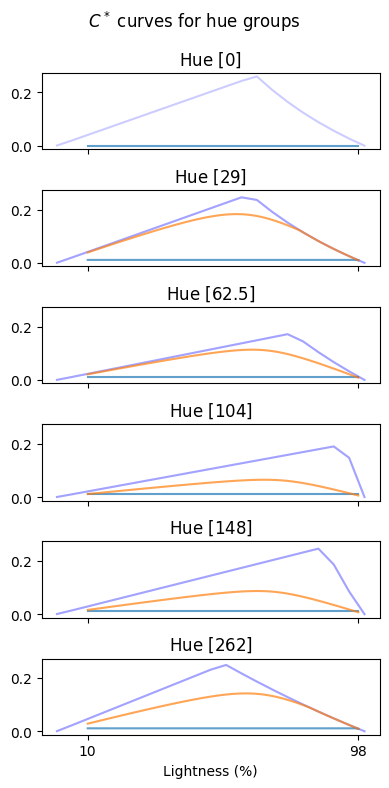

In [8]:
ax_h_map = {}
fig, axes = plt.subplots(
    len(monotone_h_map),
    1,
    sharex=True,
    sharey=True,
    figsize=(4, 8)
)

for i, h_str in enumerate(h_L_points_Cstar):
    _h = h_map[h_str]
    L_points_Cstar = h_L_points_Cstar[h_str]
    L_space_Cmax = h_Lspace_Cmax[h_str]
    
    if _h not in ax_h_map:
        ax_h_map[_h] = axes[i]
    ax = ax_h_map[_h]

    # plot Cmax and Cstar
    ax.plot(L_space, L_space_Cmax, c="b", alpha=0.2)
    ax.plot(L_points, L_points_Cstar, alpha=0.7)
    
    ax.title.set_text(f"Hue [${_h}$]")
    
axes[-1].set_xlabel("Lightness (%)")
axes[-1].set_xticks([L_points[0], L_points[-1]])

fig.tight_layout()
fig.subplots_adjust(top=0.9)

plt.suptitle("$C^*$ curves for hue groups")
plt.show()

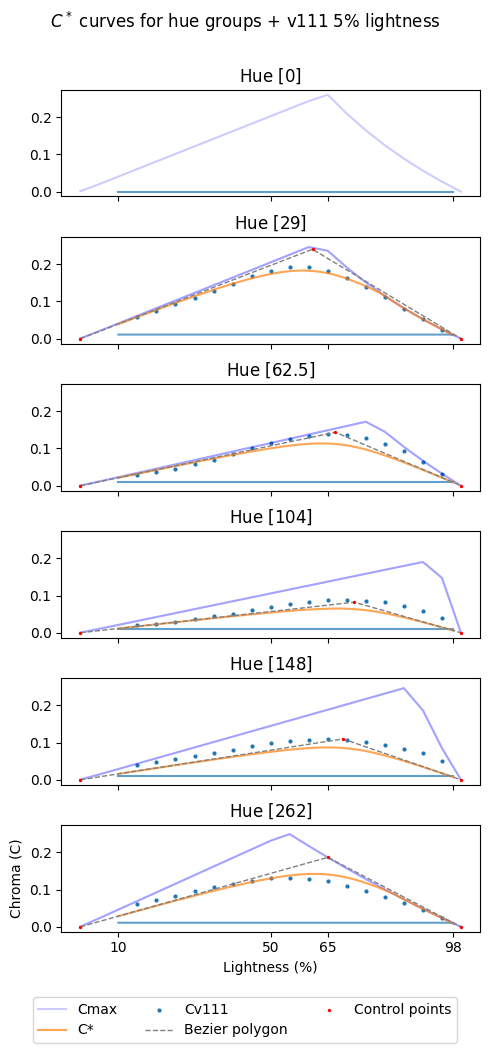

In [9]:
v111_L_space = list(range(15, 95+1, 5))
v111_hC_points = {
    "red": [0.058, 0.074, 0.092, 0.11, 0.128, 0.147, 0.167, 0.183, 0.193, 0.193, 0.182, 0.164, 0.14, 0.112, 0.081, 0.052, 0.024],
    "orange": [0.030, 0.038, 0.046, 0.058, 0.07, 0.084, 0.1, 0.114, 0.125, 0.134, 0.138, 0.136, 0.128, 0.112, 0.092, 0.064, 0.032],
    "yellow": [0.02, 0.024, 0.03, 0.036, 0.044, 0.05, 0.06, 0.068, 0.076, 0.082, 0.088, 0.088, 0.086, 0.082, 0.072, 0.058, 0.04],
    "green": [0.0401, 0.048, 0.056, 0.064, 0.072, 0.08, 0.09, 0.098, 0.104, 0.108, 0.11, 0.108, 0.102, 0.094, 0.084, 0.072, 0.05],
    "blue": [0.06, 0.072, 0.084, 0.096, 0.106, 0.116, 0.124, 0.13, 0.132, 0.128, 0.122, 0.11, 0.096, 0.08, 0.064, 0.044, 0.023],
}

ax_h_map = {}
fig, axes = plt.subplots(
    len(monotone_h_map),
    1,
    sharex=True,
    sharey=True,
    figsize=(5, 10)
)

for i, h_str in enumerate(h_L_points_Cstar):
    _h = h_map[h_str]
    L_points_Cstar = h_L_points_Cstar[h_str]
    L_space_Cmax = h_Lspace_Cmax[h_str]
    
    if _h not in ax_h_map:
        ax_h_map[_h] = axes[i]
    ax = ax_h_map[_h]

    # plot Cmax and Cstar
    ax.plot(L_space, L_space_Cmax, c="b", alpha=0.2, label='Cmax')
    ax.plot(L_points, L_points_Cstar, alpha=0.7, label='C*')

    if h_str in v111_hC_points:
        ax.scatter(v111_L_space, v111_hC_points[h_str], s=4, label='Cv111')
        
    if h_str in h_ctrl_L_C:
        cpts = h_ctrl_L_C[h_str]
        cpt_x, cpt_y = cpts[:, 0], cpts[:, 1]
        h_w = h_weights.get(h_str, 1)
        
        P0, P1, P2 = cpts[0], cpts[1], cpts[2]
        d0 = 2 * h_w * (P1 - P0)
        d2 = 2 * h_w * (P2 - P1)

        handle_scale = 0.25
        H0 = P0 + handle_scale * d0
        H2 = P2 - handle_scale * d2
    
        # ax.plot([P0[0], H0[0]], [P0[1], H0[1]], color='tab:blue', lw=1)
        # ax.plot([P2[0], H2[0]], [P2[1], H2[1]], color='tab:orange', lw=1)
        
        ax.plot(cpt_x, cpt_y, '--', color='gray', lw=1, label='Bezier polygon')
        ax.scatter(cpt_x, cpt_y, color='red', zorder=5, s=2, label='Control points')
        
    ax.title.set_text(f"Hue [${_h}$]")
    
axes[-1].set_ylabel("Chroma (C)")
axes[-1].set_xlabel("Lightness (%)")
axes[-1].set_xticks([L_points[0], 50, 65, L_points[-1]])

fig.tight_layout()
fig.subplots_adjust(top=0.9)

handles, labels = axes[-1].get_legend_handles_labels()
unique = dict(zip(labels, handles))
fig.legend(unique.values(), unique.keys(), loc='lower center', bbox_to_anchor=(0.5, -0.06), ncol=3)

plt.suptitle("$C^*$ curves for hue groups + v111 5% lightness")
plt.show()

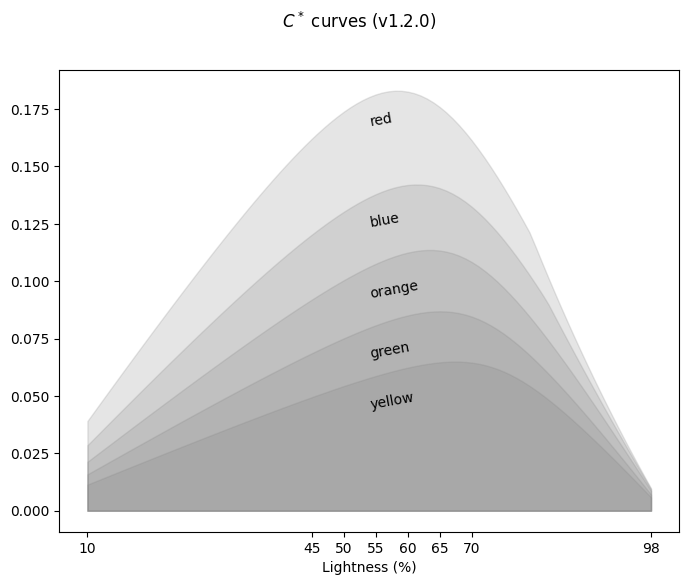

In [10]:
from numpy import arctan2, degrees

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for h_str in h_L_points_Cstar:
    if h_str not in accent_h_map:
        continue
    ax.fill_between(L_points, h_L_points_Cstar[h_str], alpha=0.2, color='grey', label=h_str)

    x, y = L_points, h_L_points_Cstar[h_str]
    n = int(0.5*len(x))
    ax.text(x[n], y[n]-0.01, h_str, rotation=10, va='center', ha='left')
    
ax.set_xlabel("Lightness (%)")
ax.set_xticks([L_points[0], 45, 50, 55, 60, 65, 70, L_points[-1]])
plt.suptitle("$C^*$ curves (v1.2.0)")
fig.show()

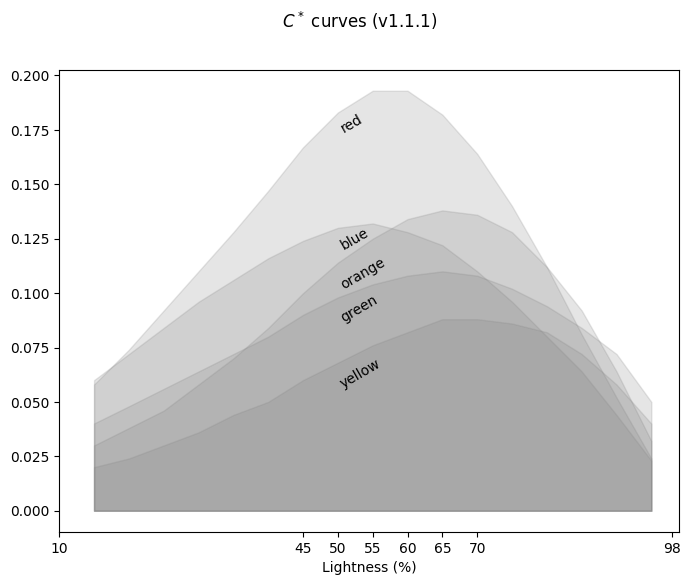

In [11]:
from numpy import arctan2, degrees

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for h_str in h_L_points_Cstar:
    if h_str not in accent_h_map:
        continue
    ax.fill_between(v111_L_space, v111_hC_points[h_str], alpha=0.2, color='grey', label=h_str)

    x, y = v111_L_space, v111_hC_points[h_str]
    n = int(0.46*len(x))
    ax.text(x[n], y[n]-0.005, h_str, rotation=30, va='center', ha='left')
    
ax.set_xlabel("Lightness (%)")
ax.set_xticks([L_points[0], 45, 50, 55, 60, 65, 70, L_points[-1]])
plt.suptitle("$C^*$ curves (v1.1.1)")
fig.show()

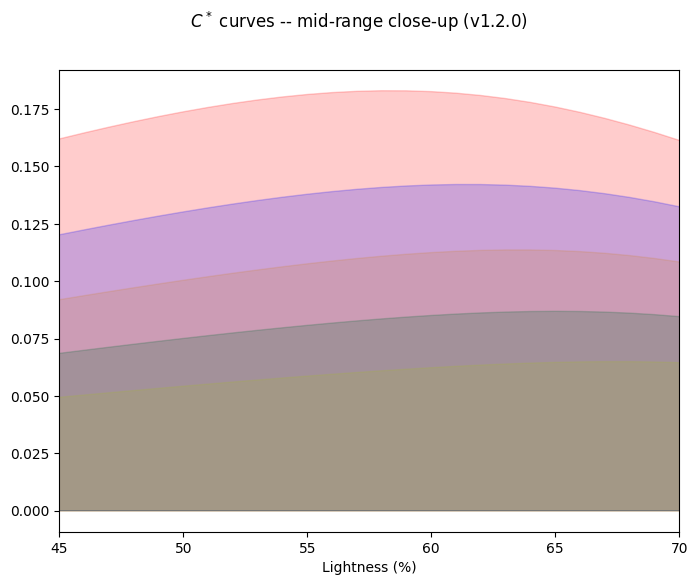

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for h_str in h_L_points_Cstar:
    if h_str not in accent_h_map:
        continue
    ax.fill_between(L_points, h_L_points_Cstar[h_str], alpha=0.2, color=h_str)
    
    
ax.set_xlabel("Lightness (%)")
ax.set_xticks([L_points[0], 45, 50, 55,   60, 65, 70, L_points[-1]])
ax.set_xlim(45, 70)
plt.suptitle("$C^*$ curves -- mid-range close-up (v1.2.0)")
fig.show()

In [13]:
# write files -- QBR = "quadratic bezier rational"
PALETTE_DIR = "palettes"

toml_content = '\n'.join(toml_lines)
with Path(PALETTE_DIR, 'monobiome-vQBRsn.toml').open('w') as f:
    f.write(toml_content)
print("[TOML] written")
    
with Path(PALETTE_DIR, 'monobiome-vQBRsn-oklch.json').open('w') as f:
    json.dump(oklch_hL_dict, f)
print("[JSON] written")

[TOML] written
[JSON] written
